# Importing Modules

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

from scipy.sparse import csr_matrix
from scipy.sparse import save_npz, load_npz 
from joblib import dump, load 

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
from pprint import pprint

import string
import os
import re

import pandas as pd
import numpy as np

# Sentiment Analysis


In [2]:
global_clean_tweets_df = pd.read_csv("../data/global_twitter_preprocessed_data.csv")
global_clean_tweets_df.head()

,created_at,source,full_text,polarity,subjectivity,sentiment,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,2022-08-07 22:31:20+00:00,Twitter for Android,RT @i_ameztoy Extra random image I Lets focus ...,-1.250000e-01,0.190625,negative,en,15760,2,i_ameztoy,20497,2621,not_found,['City'],['i_ameztoy'],NaN
1,2022-08-07 22:31:16+00:00,Twitter for Android,RT @IndoPac_Info #Chinas media explains the mi...,-1.000000e-01,0.100000,negative,en,6967,201,ZIisq,65,272,not_found,"['China', 'Taiwan']",['IndoPac_Info'],NaN
2,2022-08-07 22:31:07+00:00,Twitter for Android,China even cut off communication they dont anw...,0.000000e+00,0.000000,neutral,en,2166,0,Fin21Free,85,392,not_found,['XiJinping'],['ZelenskyyUa'],Netherlands
3,2022-08-07 22:31:06+00:00,Twitter for Android,Putin to #XiJinping I told you my friend Taiwa...,1.000000e-01,0.350000,positive,en,2166,0,Fin21Free,85,392,not_found,['XiJinping'],[],Netherlands
4,2022-08-07 22:31:04+00:00,Twitter for iPhone,RT @ChinaUncensored I’m sorry I thought Taiwan...,-6.938894e-18,0.556250,negative,en,17247,381,VizziniDolores,910,2608,not_found,[],['ChinaUncensored'],Ayent Schweiz


In [3]:
global_clean_tweets_df['sentiment'].value_counts()


neutral     8980
positive    8187
negative    4833
Name: sentiment, dtype: int64

In [4]:
# New Dataframe Needed Columns
clean_df = global_clean_tweets_df[["full_text", "polarity","sentiment"]]
clean_df.head()

,full_text,polarity,sentiment
0,RT @i_ameztoy Extra random image I Lets focus ...,-1.250000e-01,negative
1,RT @IndoPac_Info #Chinas media explains the mi...,-1.000000e-01,negative
2,China even cut off communication they dont anw...,0.000000e+00,neutral
3,Putin to #XiJinping I told you my friend Taiwa...,1.000000e-01,positive
4,RT @ChinaUncensored I’m sorry I thought Taiwan...,-6.938894e-18,negative


In [5]:
#Neutral sentiment removing
clean_df = clean_df[clean_df['sentiment'] != 'neutral']
clean_df

,full_text,polarity,sentiment
0,RT @i_ameztoy Extra random image I Lets focus ...,-1.250000e-01,negative
1,RT @IndoPac_Info #Chinas media explains the mi...,-1.000000e-01,negative
3,Putin to #XiJinping I told you my friend Taiwa...,1.000000e-01,positive
4,RT @ChinaUncensored I’m sorry I thought Taiwan...,-6.938894e-18,negative
5,RT @benedictrogers We must not let this happen...,2.000000e-01,positive
...,...,...,...
21995,RT @IndoPac_Info A good infographic of #Chinas...,7.000000e-01,positive
21996,RT @IndoPac_Info A good infographic of #Chinas...,7.000000e-01,positive
21997,@Reuters Thanks #Pelosi smart move,2.071429e-01,positive
21998,RT @IndoPac_Info #Taiwan peoples Desire for Un...,5.000000e-02,positive


In [6]:
(X, y) = clean_df['full_text'], clean_df['sentiment']


In [7]:
trigram_vectorizer = CountVectorizer(ngram_range=(1, 3))
trigram_vectorizer.fit(X.values)

CountVectorizer(ngram_range=(1, 3))

In [8]:
x_trigram_vectorizer = trigram_vectorizer.transform(X.values)


In [9]:
# Model Train Function
def train_sentiment(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    classifier = SGDClassifier()
    classifier.fit(X_train, y_train)
    train_score = classifier.score(X_train, y_train)
    test_score = classifier.score(X_test, y_test)
    print('Train score:',round(train_score, 2))
    print('Test score:', round(test_score, 2))

In [10]:
train_sentiment(x_trigram_vectorizer, y.values, 'Trigram Scores')


Train score: 1.0
Test score: 0.94


# Topic Modelling


In [11]:
tweets_df = global_clean_tweets_df
tweets_df['full_text']=tweets_df['full_text'].astype(str)
tweets_df['full_text'] = tweets_df['full_text'].apply(lambda x: x.lower())
tweets_df['full_text']= tweets_df['full_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

In [17]:
#Get List of Words From Tweets For Feature Engineering
sentence_list = [tweet for tweet in tweets_df['full_text']]
word_list = [sent.split() for sent in sentence_list]

In [13]:

#Create dictionary which contains Id and word
word_to_id = corpora.Dictionary(word_list)
corpus= [word_to_id.doc2bow(tweet) for tweet in word_list]

In [14]:
# LDA Model Building
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                    id2word=word_to_id,
                    num_topics=5,
                    random_state=100,
                    update_every=1,
                    chunksize=100,
                    passes=10,
                    alpha='auto',
                    per_word_topics=True)

In [18]:
pprint(lda_model.show_topics(formatted=False))


[(0,
  [('the', 0.049501646),
   ('rt', 0.03135388),
   ('taiwan', 0.025645547),
   ('to', 0.024089968),
   ('for', 0.02087603),
   ('a', 0.01593184),
   ('on', 0.015133515),
   ('what', 0.014984616),
   ('of', 0.014115026),
   ('out', 0.013921501)]),
 (1,
  [('rt', 0.041306533),
   ('taiwans', 0.038098134),
   ('a', 0.025164707),
   ('of', 0.023352956),
   ('minister', 0.022025146),
   ('hotel', 0.020213144),
   ('travel', 0.019537315),
   ('an', 0.019209001),
   ('to', 0.017373746),
   ('his', 0.016095875)]),
 (2,
  [('the', 0.05342079),
   ('to', 0.045532737),
   ('rt', 0.03461975),
   ('taiwan', 0.03200572),
   ('china', 0.024156885),
   ('in', 0.020660156),
   ('and', 0.020416649),
   ('is', 0.018076437),
   ('us', 0.015644714),
   ('that', 0.012379313)]),
 (3,
  [('taiwan', 0.047656145),
   ('rt', 0.04506844),
   ('of', 0.03825928),
   ('on', 0.031098938),
   ('a', 0.024582148),
   ('the', 0.023814503),
   ('in', 0.014873344),
   ('indopacinfo', 0.014412582),
   ('military', 0.01

In [19]:
# Perplexity Computing
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]


Perplexity:  -7.442255861806041


In [20]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=word_to_id, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


 Ldamodel Coherence Score/Accuracy on Tweets:  0.2626866335761401


In [21]:
# Importing Modules for Visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [23]:
# Topic Visualization
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, word_to_id)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.151727  0.026330       1        1  39.738682
3      0.073736  0.168148       2        1  26.353650
0      0.110279  0.018624       3        1  15.138973
4     -0.315102  0.077585       4        1  10.930515
1     -0.020640 -0.290688       5        1   7.838179, topic_info=        Term          Freq         Total Category  logprob  loglift
57        to  10862.000000  10862.000000  Default  30.0000  30.0000
19       the  16826.000000  16826.000000  Default  29.0000  29.0000
421  taiwans   1404.000000   1404.000000  Default  28.0000  28.0000
61         a   6765.000000   6765.000000  Default  27.0000  27.0000
15        rt  17193.000000  17193.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
57        to    640.270631  10862.741039   Topic5  -4.0528  -0.2850
37    taiwan    573.296930  15787.098916   Topic5  -4.1633  -0.7694
114       on    479.372574   6637.758187   Topic5  -4.3422  -0.0819
9         in    473.472517   6549.148358   Topic5  -4.3546  -0.0808
19       the    358.701056  16826.359886   Topic5  -4.6322  -1.3020

[284 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1443      3  0.995047    11
294       1  0.998840     3
183       2  0.998765   4th
1163      1  0.045084     5
1163      3  0.952917     5
...     ...       ...   ...
149       3  0.996131    yi
82        1  0.282216   you
82        4  0.717757   you
571       1  0.011276  your
571       4  0.988520  your

[323 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 5, 2])

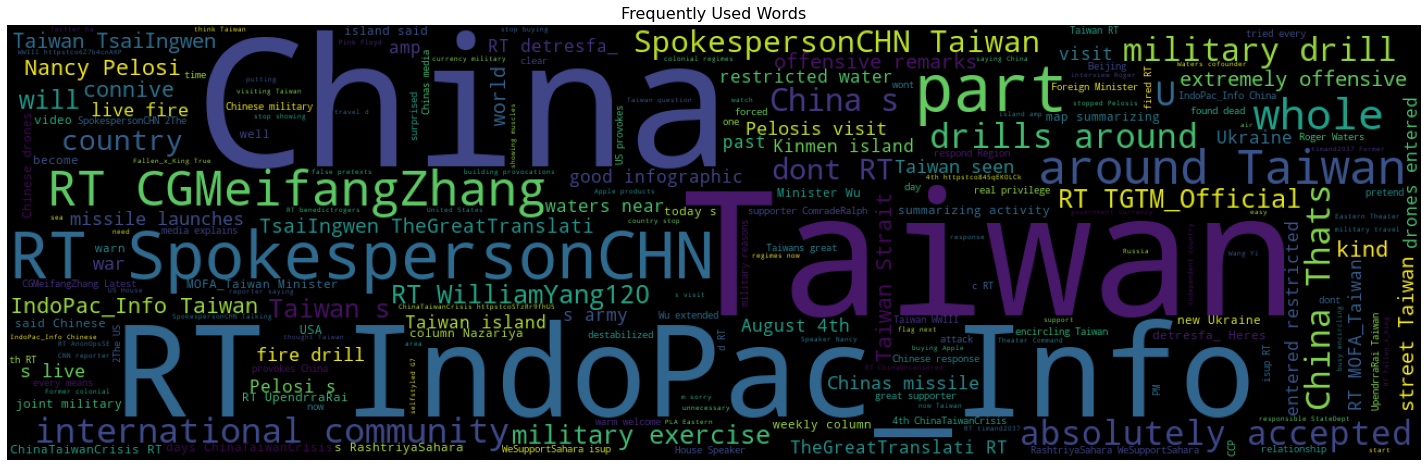

In [28]:
# Depicting Mostly Used Words
plt.figure(figsize=(28,8))
plt.imshow(WordCloud(width=1300,height=400,stopwords=STOPWORDS).generate(' '.join(clean_df['full_text'].values)))
plt.axis('off')
plt.title("Frequently Used Words",fontsize=16)
plt.show()